# 16-1. 불안한 시선 이펙트 추가하기  
## 16-1. 들어가며  
지난번에 이어 눈동자를 검출하는 방법을 다뤄보자.  
이번 시간 목표는  
  1. 공개 데이터 사용해서 라벨 직접 모아보기
  2. 색상 값을 이용한 검출 방법
  3. 라벨링 툴 만들기 - point selection
  4. 째려보는 효과 구현하기  
  
### 준비물  
-----------------------------------------------
프로젝트를 위한 디렉토리를 생성해보자  
```
$ mkdir -p ~/aiffel/coarse_to_fine/data
```
파일을 다운받아 디렉토리에서 작업하자  
```
$ cd ~/aiffel/coarse_to_fine
$ wget https://aiffelstaticprd.blob.core.windows.net/media/documents/coarse_to_fine_pjt.zip
$ unzip coarse_to_fine_pjt.zip
```  


## 16-2. 위치 측정을 위한 라벨링 툴 만들기(1) OpenCV 사용  
이전 노드에서 True/False를 라벨링하는 도구를 만들었는데, 품질이 좋지 못한 데이터는 직접 입력을 해야 합니다.
즉 눈동자 위치를 선택할 수 있는 도구를 만들어보겠습니다.  
정확한 곳을 지정하기 위해 마우스를 사용해야 하는데 다행이도 OpenCV에서 마우스 이벤트를 callback 함수로 지원합니다.  
[콜백함수](https://satisfactoryplace.tistory.com/18)  
**Q1. callback 함수는 무엇인가요?**  
ANS) 어떤 이벤트에 의해 호출되어지는 함수, 다른 함수의 인자로 이용되는 함수  
OpenCV에서 지원하는 마우스 이벤트 형태는 아래 참고자료를 통해 확인해 보세요.
[참고자료](https://opencv-python.readthedocs.io/en/latest/doc/04.drawWithMouse/drawWithMouse.html)  
**Q2. OpenCV에서 마우스 이벤트를 확인하고 callback을 호출하는 함수는 무엇인가요?**  
ANS)cv2.setMouseCallback()  
**Q3. OpenCV에서 마우스 왼쪽 버튼이 눌러졌을 때 on 되는 flag 는 무엇인가요?**  
ANS)cv2.EVENT_LBUTTONDOWN  

## 16-3. 위치 측정을 위한 라벨링 툴 만들기 (2) 툴 만들기  
OpenCV의 마우스 이벤트를 이용해서 라벨링 툴을 만들어보자  
아래 코드를 keypoint_using_mouse.py로 저장  
아래 코드는 cv2를 주로 이용하며 기존위치를 사용하지 않고 새로 위치를 정하기 때문에 img_path만 불러오고, flg_button은 마우스 이벤트가 발생할 때 사용할 불리언 타입 전역변수.  
```
import os
from os.path import join
from glob import glob
import cv2
import argparse
import numpy as np
import json
from pprint import pprint

args = argparse.ArgumentParser()

# hyperparameters
args.add_argument('img_path', type=str, nargs='?', default=None)

config = args.parse_args()

flg_button = False
```  
사용할 함수를 만들어보겠습니다.  
먼저 img_path가 유효한지 체크하고(img_path에 디렉토리가 입력될때 해당 디렉토리 내의 첫 이미지를 img_path에 입력하고 경로반환) 이미지간 이동할 move()함수도 선업합니다.  
```
def check_dir():
    if config.img_path is None \
        or len(config.img_path) == 0 \
        or config.img_path == '' \
        or os.path.isdir(config.img_path):
        root = os.path.realpath('./')
        if os.path.isdir(config.img_path):
            root = os.path.realpath(config.img_path)
        img_list = sorted(glob(join(root, '*.png')))
        img_list.extend(sorted(glob(join(root, '*.jpg'))))
        config.img_path = img_list[0]

    img_dir = os.path.dirname(os.path.realpath(config.img_path))

    return img_dir

def move(pos, idx, img_list):
    if pos == 1:
        idx += 1
        if idx == len(img_list):
            idx = 0
    elif pos == -1:
        idx -= 1
        if idx == -1:
            idx = len(img_list) - 1
    return idx
```
마우스 콜백함수 정의  
```
# Mouse callback function
def select_point(event, x,y, flags, param):
    global flg_button, gparam # 전역변수 gparam에 img, point정보 저장
    img = gparam['img']

    if event == cv2.EVENT_LBUTTONDOWN:
        flg_button = True

    if event == cv2.EVENT_LBUTTONUP and flg_button == True:
        flg_button = False
        print (f'({x}, {y}), size:{img.shape}')
        gparam['point'] = [x,y] #마우스 왼쪽 누를 때마다 point에 x,y정보를 리스트로 저장
```   
main 함수인 blend_view()를 구현하자  
```
def blend_view():
    global gparam
    gparam = {}
    cv2.namedWindow('show', 0)
    cv2.resizeWindow('show', 500, 500)

    img_dir = check_dir()

    fname, ext = os.path.splitext(config.img_path)
    img_list = [os.path.basename(x) for x in sorted(glob(join(img_dir,'*%s'%ext)))]

    dict_label = {}
    dict_label['img_dir'] = img_dir
    dict_label['labels'] = {}

    json_path = os.getenv('HOME')+'/aiffel/coarse_to_fine/eye_annotation.json'
    json_file = open(json_path, 'w', encoding='utf-8')

    idx = img_list.index(os.path.basename(config.img_path))
    pfname = img_list[idx]
    orig = None
    local_point = [] # 저장할 point list
    while True:
        start = cv2.getTickCount()
        fname = img_list[idx]
                # 파일의 변경이 없거나 이미지가 없을 때, point 를 초기화함
        if pfname != fname or orig is None:
            orig = cv2.imread(join(img_dir, fname), 1)
            gparam['point'] = []
            pfname = fname
                # 저장할 point(local point) 와 새로 지정한 gparam['point'] 가 변경된 경우,
                # local_point 를 업데이트
        if local_point != gparam['point']:
            orig = cv2.imread(join(img_dir, fname), 1)
            local_point = gparam['point']

        img_show = orig
        gparam['img'] = img_show
        cv2.setMouseCallback('show', select_point) # mouse event

        if len(local_point) == 2:
            img_show = cv2.circle(img_show, tuple(local_point),
                                  2, (0,255,0), -1)
            dict_label['labels'][fname] = local_point # label 로 저장

        time = (cv2.getTickCount() - start) / cv2.getTickFrequency() * 1000

        if img_show.shape[0] > 300:
            cv2.putText(img_show, '%s'%fname, (5,10), cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.5, (255,255,255))

        print (f'[INFO] ({idx+1}/{len(img_list)}) {fname}... time: {time:.3f}ms', end='\r')

        cv2.imshow('show', img_show)

        key = cv2.waitKey(1)
        if key == 27:
            return -1
        if key == ord('n'):
            idx = move(1, idx, img_list)
        elif key == ord('p'):
            idx = move(-1, idx, img_list)
        elif key == ord('v'):
            print ()
            pprint (dict_label)
            print ()
        elif key == ord('s'):
            json.dump(dict_label, json_file, indent=2)
            print (f'[INFO] < {json_path} > saved!')

if __name__ == '__main__':
    blend_view()
```  
blend_view함수는 이론노드에서 만든 라벨링 툴의 구조를 비슷하게 구현하되 다른 점 3가지는 아래와 같습니다.  
  * 마우스 이벤트를 사용하기 위해 무한루프를 사용해서 gparam을 입력 받을 수 있게 한 것
  * 이미지 변경이 없다면 gparam['point'] 를 초기화하지 않을 것
  * 이미지 변경이 없더라도 callback 함수에서 gparam 변경이 일어나는 경우는 수정할 것  


아래코드로 이미지를 다운받고 코드를 터미널에서 실행해봅시다.  
```
$ cd ~/aiffel/coarse_to_fine
$ wget https://aiffelstaticprd.blob.core.windows.net/media/original_images/1_hZAciQ9.png -O ./data/eye.png
$ python keypoint_using_mouse.py ./data/eye.png
```
눈동자 지점을 클릭한 후 s를 눌러 저장하면 esc를 눌러 프로그램을 종료할 때 ~/aiffel/coarse_to_fine/eye_annotation.json 에 레이블이 저장됩니다.  
이제 레이블을 모아서 학습시킬 수 있습니다!

## 16-4. 데이터를 모아보자.  
라벨링할 초기 데이터를 수집해야 하는데, 직접 촬영하기에는 시간과 노력이 많이 들기에 공개된 데이터를 적극적으로 활용해보자.  
우리가 사용할 데이터의 조건은  
  1. 눈이 crop 되어 있고 눈동자 위치를 라벨로 가지고 있는 데이터
  2. 얼굴 랜드마크(face landmark)를 가지고 있는 데이터  
  3. 얼굴 이미지를 가지고 있는 데이터
위의 3가지로, 1번째에 해당하는 데이터셋은 [BioID](https://www.bioid.com/facedb/)가 있습니다.  
**Q4. BioID는 몇 장의 이미지를 가지고 있나요? 이미지 해상도는 얼마일까요?**  
ANS) 1,521장의 gray image, 384x286  
**Q5. BioID는 몇 명의 사람으로 구성돼 있나요?**  
ANS)23명  
BioID는 우리 문제 해결을 위한 데이터셋이지만, 규모가 너무 작기에 다른 데이터셋을 찾을 필요가 있습니다.  
따라서 얼굴 랜드마크가 제공되어 눈 부분을 쉽게 크롭할 수 있는 데이터를 생각해봅시다.  

### 랜드마크를 제공하는 데이터셋을 찾아보자  
------------------------------------------------------  
우리는 dlib 패키지의 얼굴 랜드마크를 사용해왔으니, dlib 패키지를 구현하기 위해 사용된 랜드마크가 어떤 데이터셋으로 학습되었는지를 통해 데이터를 찾아볼 수 있습니다.  
구글게 dlib face landmark dataset을 치면 [여기](http://dlib.net/face_landmark_detection.py.html)가 나오는데 주석에 어떤 데이터셋을 사용했는지 안내되어 있습니다.  
```
#   and was trained on the iBUG 300-W face landmark dataset (see
#   https://ibug.doc.ic.ac.uk/resources/facial-point-annotations/):
```  
iBUG 300-W라는 데이터셋으로 학습했다고 하니 이 데이터셋을 이용하는 방법도 유용할 것 같습니다.  
이번에는 운이 좋아 데이터셋을 찾을 수 있었지만, 실무에서 내가 원하는 문제와 관련된 도메인 데이터셋이 없기 때무에 3번 방법도 고려해야 합니다.  
3번 연습을 위해서 LFW 데이터셋을 사용해봅시다.  
이 데이터셋은 안면인식과 관련된 데이터셋으로 얼굴포함된 이미지만 있고, 랜드마크 정보가 없는 데이터셋입니다.  
따라서 dlib를 적용해서 랜드마크와 얼굴 위치를 찾고 눈을 크롭한뒤에 라벨링할수 있습니다.  
데이터는 [여기](http://vis-www.cs.umass.edu/lfw/lfw.tgz)서 다운로드 가능합니다.  
```
$ cd ~ && wget http://vis-www.cs.umass.edu/lfw/lfw.tgz
$ tar -xvzf lfw.tgz
```

## 16-5. Mean-shift를 이용한 눈동자 검출 방법 (1) 이론  
<img src="eye_detect.png">  
쉽게 생각할만한 눈동자 검출 방식은 **"눈동자는 주변 부분에 비해 어두운 색을 지니고 있다."** 를 가정으로 반전된 1D 이미지에서 최댓값을 찾는 방법입니다  
<img src="eye.png">  
위와 같이 눈동자만 잘 보이면 다행이지만, 아래와 같이 머리카락이 같이 나타나면 눈동자보다 가장자리에 수렴할 확률이 높습니다.  
<img src="hair.png">  
2차원 블러 특성 이미지(feature image)에서 눈동자가 2차원 정규분포로 나타나는 영역이 있는 것으로 보이고, 1차원 누적 그래프를 봤을 때 x축으로 2개의 봉우리가 있고 최댓값을 찾는 알고리즘을 왼쪽부터 시작했다면 가장 왼쪽에서 만난 255에 수렴할 것이기에 1D 누적 그래프와 2D 특성이미지를 모두 사용합니다.  
<img src="step.png">  
  **1. 이미지 중심점을 초기값으로 설정하겠습니다.**
  눈의 중심에 눈동자가 있을 확률이 높기 때문에 초기값으로 정하기에 아주 좋습니다.)
  **2. 중심점을 기준으로 작은 box를 설정합니다.**
  box의 크기는 문제에 따라 적절한 값을 설정해야 합니다.
  그림에서 회색박스를 생각하시면 됩니다.
  **3. box 내부의 pixel 값을 이용해서 '무게중심'을 찾습니다.**
  이 때 무게중심은 pixel intensity를 weight 로 사용할 수 있습니다.
  **4. 찾은 무게중심을 새로운 box의 중심으로 설정합니다.**
  이 단계에서 박스가 이동하게 됩니다. 이제 회색박스에서 초록색박스로 관심영역이 이동했습니다.
  **5. 다시 초록색 박스를 기준으로 2-4를 반복합니다.**
  **6. 중심점이 수렴할 때 까지 2~5를 반복하면 수렴한 점의 위치로 눈동자를 찾을 수 있습니다.**  

위의 방식을 머신러닝의 Mean Shift알고리즘과 비슷하며 mean shift는 탐색반경 내 데이터 포인트의 평균을 구하고 평균 위치로 이동을 반복해 가면서 데이터 분포의 중심으로 이동합니다.[Mean Shift 추적](https://darkpgmr.tistory.com/64)  

**Q6. mean shift를 이용해서 global optima를 찾을 수 있는 방법을 설명해주세요.**  
ANS) 그런 방법은 존재하지 않는다. mean shift는 local optima에만 수렴하기 때문이다.  
**Q7. mean shift 의 단점은 무엇인가요?**  
ANS) 초기값에 따라 수렴 위치가 달라진다. 항상 일정한 성능을 보장하기 힘들다.  
**Q8. mean shift는 컴퓨터 비전의 어떤 분야에 응용할 수 있나요?**  
ANS) Mean Shift는 물체추적(object tracking), 영상 세그멘테이션(segmentation), 데이터 클러스터링(clustering), 경계를 보존하는 영상 스무딩(smoothing) 등 다양하게 활용될 수 있다.  
**Q9. 1차원 데이터 분포에 mean shift를 적용하면 어떤 형태를 나타내는지 이야기해 봅시다.**  
가우시안 분포에서 등산하듯이 위로 올라가는 형태를 나타냅니다.

## 16-6. Mean-shift를 이용한 눈동자 검출 방법 (2) 실습  
눈동자를 검출하는 mean shift 방법을 코드로 구현. 지난번 노드에서 했던 코드를 eye_center_basic.py에 저장하고 베이스라인으로 사용합니다.  
이 코드의 동작은 show_substep argument 옵션을 True로 주게 되면 매 스텝마다 작동을 차례차례 확인해볼수 잇습니다. 옵션을 False로 주거나 생략하면 최종결과만 확인.  
```
$ cd ~/aiffel/coarse_to_fine && python eye_center_basic.py True
```  
이제 mean shift 알고리즘을 적용하여 eye_center_meanshift.py를 생성해보자  
```
$ cd ~/aiffel/coarse_to_fine && cp eye_center_basic.py eye_center_meanshift.py
```
눈 이미지를 low pass filter(bilateral)를 이용해서 smoothing.  
다음으로 1차원 값으로 누적시킨 후 y축 기준으로 최댓값을 찾아서 y축의 중심점 좌표를 먼저 얻어냅니다.(y축이 x축에 비해 변화가 적기에 간단히 구현)  
x축은 1차원 최댓값 지점을 기준으로 mean shift 수행. 양끝단에 수렴하는 예외를 처리한 후 결과를 출력  
결과를 뽑아보자  
```
$ cd ~/aiffel/coarse_to_fine && python eye_center_meanshift.py
```  
여전히 눈동자 중심이 아니어서 아쉽고 기존 머신러닝 알고리즘으로는 큰 성능향상을 기대하기 어려보입니다.  
하지만, 예외상황에 좀더 강건한 모델을 만들수 있어서 일반화에 좀더 가까워졌습니다.

## 16-7. 키포인트 검출 딥러닝 모델 만들기 (1) 데이터 확인  
더 좋은 성능을 위해서 딥러닝 모델을 만들어보겠습니다.  
이번 단계에는 대량의 눈동자 위치 라벨이 필요합니다. 앞에서 만든 coarse dataset또는 annotation한 라벨이 1만개 이상있어야 성능확인이 가능합니다.  
이전 단계의 눈동자 검출 방법을 LFW 데이터셋에 적용하여 필요한 데이터셋을 생성.  
데이터셋을 생성하는 코드 prepare_eye_dataset.py를 사용하면 사용할 데이터셋을 LFW 데이터셋으로부터 가공,생성  
생성된 데이터셋은 ~/lfw/data/train, ~/lfw/data/valid 아래에서 확인  
```
$ cd ~/aiffel/coarse_to_fine && python prepare_eye_dataset.py
```

In [1]:
import tensorflow as tf
import numpy as np
import math
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.callbacks import LearningRateScheduler

TensorFlow Hub에서 제공하는 pretrained image feature embedding을 가지고 fine tuning을 해보겠습니다.  
가지고 있는 데이터를 케라스 ImageDataGenerator 형식으로 읽습니다. 저는 라벨을 image 형태로 저장해 두었습니다.

In [2]:
#train 23712쌍, val 2638쌍.
#배치 사이즈인 32의 배수조건만 맞춰주면 된다.
import glob
import os

home_dir = os.getenv('HOME')+'/lfw'
list_image = sorted(glob.glob(home_dir+'/data/train/input/img/*.png'))
list_label = sorted(glob.glob(home_dir+'/data/train/label/mask/*.png'))
print (len(list_image), len(list_label))

# 32의 배수를 벗어나는 파일 경로들을 담은 list
list_image_out_of_range = list_image[len(list_image) - (len(list_image) % 32):]
list_label_out_of_range = list_label[len(list_label) - (len(list_label) % 32):]

# 해당 list가 존재한다면, 파일 삭제
if list_image_out_of_range:
    for path in list_image_out_of_range:
        os.remove(path)
if list_label_out_of_range:
    for path in list_label_out_of_range:
        os.remove(path)

IMAGE_SHAPE = (80, 120)
data_root = home_dir+'/data/train/input'
label_root = home_dir+'/data/train/label'

image_generator = tf.keras.preprocessing.image.ImageDataGenerator()
label_generator = tf.keras.preprocessing.image.ImageDataGenerator()
image_data = image_generator.flow_from_directory(str(data_root), class_mode=None, target_size=IMAGE_SHAPE, batch_size=32)
label_data = label_generator.flow_from_directory(str(label_root), class_mode=None, target_size=IMAGE_SHAPE, batch_size=32)

23680 23680
Found 23680 images belonging to 1 classes.
Found 23680 images belonging to 1 classes.


아래 코드에서는 image_generator, label generator를 학습할 수 있는 입출력 형식으로 편집합니다. 텐서플로우의 제너레이터(generator) 형식을 사용하고 있기 때문에 출력 형식도 맞추어 주겠습니다.  
[제너레이터](https://tensorflow.blog/%ED%9A%8C%EC%98%A4%EB%A6%AC%EB%B0%94%EB%9E%8C%EC%9D%84-%ED%83%84-%ED%8C%8C%EC%9D%B4%EC%8D%AC/%EC%A0%9C%EB%84%88%EB%A0%88%EC%9D%B4%ED%84%B0/)  
학습 라벨을 만들 때 3개의 점을 label 이미지에 표시했습니다. 눈의 왼쪽 끝점을 1의 값으로, 오른쪽 끝점은 2의 값으로, 가장 중요한 눈 중심(눈동자)는 3으로 인코딩 했습니다. np.where() 함수로 이미지에서 좌표로 복원합니다.

In [3]:
def user_generation(train_generator, label_generator):
    h, w = train_generator.target_size
    for images, labels in zip(train_generator, label_generator):
        images /= 255.
        images = images[..., ::-1] # rgb to bgr

        list_point_labels = []
        for img, label in zip(images, labels):

            eye_ls = np.where(label==1) # leftside
            eye_rs = np.where(label==2) # rightside
            eye_center = np.where(label==3)

            lx, ly = [eye_ls[1].mean(), eye_ls[0].mean()]
            rx, ry = [eye_rs[1].mean(), eye_rs[0].mean()]
            cx, cy = [eye_center[1].mean(), eye_center[0].mean()]

            if len(eye_ls[0])==0 or len(eye_ls[1])==0:
                lx, ly = [0, 0]
            if len(eye_rs[0])==0 or len(eye_rs[1])==0:
                rx, ry = [w, h]
            if len(eye_center[0])==0 or len(eye_center[1])==0:
                cx, cy = [0, 0]

            np_point_label = np.array([lx/w,ly/h,rx/w,ry/h,cx/w,cy/h], dtype=np.float32)

            list_point_labels.append(np_point_label)
        np_point_labels = np.array(list_point_labels)
        yield (images, np_point_labels)

**Q10. 좌표로 복원할 때 eye_ls[1].mean() 으로 평균값을 구했습니다. 왜 그랬을까요? 어떤 장점을 활용하려고 한 걸까요?**  
ANS) 눈 크기가 이미지마다, 사람마다 다르기 때문에 반드시 resize를 해야 합니다. 이 때 라벨을 이미지에 하나의 점으로 표현하면 resize 과정에서 소실될 수 있습니다. 이런 단점을 극복하기 위해 라벨 이미지를 만들 때 gaussian smoothing을 적용해서 변화에 유연하게 대응 할 수 있도록 했습니다. 이 방법을 취하면 이후 augmentation을 구현할 때도 추가적인 노력없이 바로 라벨을 사용할 수 있습니다.

In [4]:
#만들어진 제네레이터로 데이터 포인트를 뽑아 관찰
# 120X80의 정해진 크기로 이미지가 잘 출력되고, 라벨또한 0~1값으로 정규화되어있는 것을 확인할 수 있다.
user_train_generator = user_generation(image_data, label_data)
for i in range(2):
    dd = next(user_train_generator)
    print (dd[0][0].shape, dd[1][0])

(80, 120, 3) [0.         0.         1.         1.         0.55833334 0.40823644]
(80, 120, 3) [0.         0.         1.         1.         0.22083333 0.28555328]


/home/ssac19/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice.
  
/home/ssac19/anaconda3/envs/aiffel/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ssac19/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app


## 16-8. 키포인트 검출 딥러닝 모델 만들기 (2) 모델 설계  
데이터가 준비되었으니 네트워크 설계.  
데이터가 없는 상황이기에 미리 학습된 모델 활용.  
TensorFlow Hub의 ResNet 특성추출기부분 백본으로 사용  
tf.keras.Sequential()을 이용해서 백본 네트워크와 fully connected layer를 쌓아서 아주 쉽게 모델을 완성할 수 있습니다. 데이터 제너레이터를 만들 때 출력을 6개((x, y) 좌표 2개 * 점 3개) 로 했기 때문에 num_classes 는 6으로 설정합니다.  

In [6]:
''' tf hub feature_extractor '''
feature_extractor_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                            input_shape=(80,120,3))

image_batch = next(image_data)
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

num_classes = 6

feature_extractor_layer.trainable = False
model = tf.keras.Sequential([
    feature_extractor_layer,
    #layers.Dense(1024, activation='relu'),
    #layers.Dropout(0.5),
    layers.Dense(num_classes, activation='sigmoid'),
])

model.summary()

(32, 2048)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              23564800  
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 12294     
Total params: 23,577,094
Trainable params: 12,294
Non-trainable params: 23,564,800
_________________________________________________________________


이 문제는 점을 맞는 위치로 추정하는 position regression 문제이기 때문에 loss와 metric을 각각 mse 와 mae 로 설정했습니다. mae 를 통해서 픽셀 위치가 평균적으로 얼마나 차이나는지 확인하면서 학습할 수 있습니다.

In [7]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='mse',
  metrics=['mae']
  )

In [8]:
#학습률을 조절하는 함수
def lr_step_decay(epoch):
      init_lr = 0.0005 #self.flag.initial_learning_rate
      lr_decay = 0.5 #self.flag.learning_rate_decay_factor
      epoch_per_decay = 2 #self.flag.epoch_per_decay
      lrate = init_lr * math.pow(lr_decay, math.floor((1+epoch)/epoch_per_decay))
      return lrate

In [9]:
steps_per_epoch = image_data.samples//image_data.batch_size
print (image_data.samples, image_data.batch_size, steps_per_epoch)
# 23712 32 741 -> 데이터를 batch_size(32) 의 배수로 맞춰 준비해 주세요. 

assert(image_data.samples % image_data.batch_size == 0)  # 데이터가 32의 배수가 되지 않으면 model.fit()에서 에러가 발생합니다.

learning_rate = LearningRateScheduler(lr_step_decay)

history = model.fit(user_train_generator, epochs=10,
                    steps_per_epoch=steps_per_epoch,
                    callbacks = [learning_rate]
                    )

23680 32 740
Epoch 1/10


/home/ssac19/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice.
  
/home/ssac19/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app


740/740 [==============================] - 23s 32ms/step - loss: 0.0210 - mae: 0.0712
Epoch 2/10
740/740 [==============================] - 16s 22ms/step - loss: 0.0143 - mae: 0.0563
Epoch 3/10
740/740 [==============================] - 16s 22ms/step - loss: 0.0138 - mae: 0.0546
Epoch 4/10
740/740 [==============================] - 16s 22ms/step - loss: 0.0133 - mae: 0.0536
Epoch 5/10
740/740 [==============================] - 16s 22ms/step - loss: 0.0132 - mae: 0.0531
Epoch 6/10
740/740 [==============================] - 16s 22ms/step - loss: 0.0129 - mae: 0.0525
Epoch 7/10
740/740 [==============================] - 16s 22ms/step - loss: 0.0129 - mae: 0.0524
Epoch 8/10
740/740 [==============================] - 16s 22ms/step - loss: 0.0128 - mae: 0.0522
Epoch 9/10
740/740 [==============================] - 16s 22ms/step - loss: 0.0128 - mae: 0.0521
Epoch 10/10
740/740 [==============================] - 16s 22ms/step - loss: 0.0128 - mae: 0.0521


## 16-9. 키포인트 검출 딥러닝 모델 만들기 (3) 평가  
검증 데이터는 섞어줄 필요가 없기에 shuffle=False옵션추가.

In [10]:
IMAGE_SHAPE = (80, 120)

home_dir = os.getenv('HOME')+'/lfw'

val_data_root = home_dir + '/data/val/input'
val_label_root = home_dir + '/data/val/label'

image_generator_val = tf.keras.preprocessing.image.ImageDataGenerator()
label_generator_val = tf.keras.preprocessing.image.ImageDataGenerator()
image_data_val = image_generator.flow_from_directory(str(val_data_root), class_mode=None, target_size=IMAGE_SHAPE, shuffle=False)
label_data_val = label_generator.flow_from_directory(str(val_label_root), class_mode=None, target_size=IMAGE_SHAPE, shuffle=False)

Found 2646 images belonging to 1 classes.
Found 2646 images belonging to 1 classes.


In [11]:
#제네레이터를 만들고 evaluate_generator()를 수행  
user_val_generator = user_generation(image_data_val, label_data_val)
mse, mae = model.evaluate_generator(user_val_generator, image_data_val.n // 32)
print(mse, mae)
# 점 픽셀갯수기준으로 점 픽셀 기준X에러 갯수 개의 픽셀 에러가 나는 것을 확인

Instructions for updating:
Please use Model.evaluate, which supports generators.


Instructions for updating:
Please use Model.evaluate, which supports generators.
/home/ssac19/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice.
  
/home/ssac19/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app


0.012717033736407757 0.05168704688549042


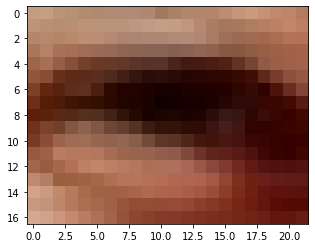

In [12]:
# img test
import cv2
import matplotlib.pyplot as plt

img = cv2.imread(val_data_root+'/img/eye_000010_l.png')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [15]:
# 이미지를 120X80으로 resize한 후 배치를 나타낼 수 있는 4차원 텐서로 변경.
# 이미지 1장만 출력할 것이니 배치크기 1로 만들자
# img test
np_inputs = np.expand_dims(cv2.resize(img, (120, 80)), axis=0)
preds = model.predict(np_inputs/255., 1)

repred = preds.reshape((1, 3, 2))
repred[:,:,0] *= 120
repred[:,:,1] *= 80
print (repred)
# 출력결과를 뽑아보면 아래와 같이 나옵니다. 1행부터 좌측, 우측, 중앙 좌표를 나타냅니다.

[[[3.3800732e-04 1.5259015e-04]
  [1.1999979e+02 7.9999916e+01]
  [4.8898815e+01 2.4125986e+01]]]


[0. 0.]
[120.  80.]
[49. 24.]


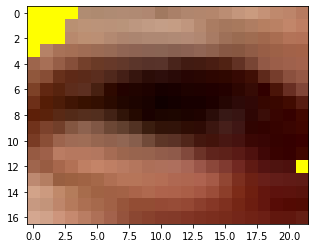

In [16]:
#결과를 이미지에 출력해 볼까요? pt 값은 120x80 으로 뽑았는데 우리가 사용하는 데이터 크기는 60x40입니다. 따라서 pt 에 0.5 를 곱해서 그림에 출력합니다.
#(주의) pt값을 뽑을때의 이미지 크기 기준(120X80)은 고정이지만, 사용하는 데이터의 크기는 매번 달라질 것입니다. 보정치 설정에 유의해 주세요.
show = img.copy()
for pt in repred[0]:
    print (pt.round())
    show = cv2.circle(show, tuple((pt*0.5).astype(int)), 3, (0,255,255), -1)

plt.imshow(cv2.cvtColor(show, cv2.COLOR_BGR2RGB))
plt.show()

## 16-10. 프로젝트: 카메라 앱에 당황한 표정 효과를 적용해보기  
<img src="image.jpg">  
그림처럼 놀라서 눈이 튀어나오는 듯 한 효과를 내봅시다. 우선 눈을 찾고, 눈에 효과를 적용해 보세요. 어려워 보여도 차근차근 한다면 충분히 간단한 프로토타입을 구현하실 수 있습니다.  

### 1. 이론 시간에 다룬 모델을 참고하여 딥러닝 모델을 설계해 봅시다.  
----------------------------------
7~9번 스텝에서 키포인트 검출을 위한 딥러닝 모델을 만들어본 바 있습니다. 이를 활용해서 눈 이미지에서 적합한 키포인트를 찾는 딥러닝 모델을 구현해 봅시다. 이 모델의 학습을 위해서는 오늘 다룬 것처럼 데이터를 모아 데이터셋을 구축하는 과정이 함께 진행되어야 할 것입니다.  
### 2. 눈동자 효과를 추가해 봅시다.
-------------------------------
추출된 눈 위치에 위의 당황한 표정의 눈 이미지를 합성해 봅시다. 이렇게 합성된 이미지를 제출하는 것까지가 오늘 프로젝트 과제의 목표입니다.